# 1. Download data and utils

In [1]:
from IPython.display import clear_output

In [2]:
!pip install emoji
# !pip install gdown
clear_output()

In [3]:
!gdown --id 1kZXyzmfWs2W1F0hOJ0yIIzN_TnF9oqHB # glove.6B.50d.txt
!gdown --id 1KqqaorkmBqi8c__RNA3OG3KoxjjKKepG # model_utils.py
!gdown --id 1ZjrS190X6AO9oIhDusj_SXLXzoEgIX2D # utils.py
!gdown --id 1rP7cr_q-C_lav2uxrIA8kJdHi2wg9EdX # data.csv
clear_output()

# 2. Import libraries

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from utils import read_csv, read_glove_vecs, convert_to_one_hot, label_to_emoji, normalize
from model_utils import pretrained_embedding_layer, sentences_to_indices
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sn

# 3. Prepare data

In [5]:
X, Y = read_csv('data.csv')
X = normalize(X)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=.2,shuffle=True,random_state=42)
print(f'X train shape: {X_train.shape}')
print(f'X test shape: {X_test.shape}')
print(f'X shape: {X.shape}')

X train shape: (150,)
X test shape: (38,)
X shape: (188,)


In [6]:
for idx in range(10):
    print(X_train[idx],label_to_emoji(Y_train[idx]))

you suck 😞
she is happy 😄
you could not solve it 😞
i like it when people smile 😄
i lost my wallet 😞
her smile is so charming 😄
lets brunch some day 🍴
he had to make a home run ⚾
my grandmother is the love of my life ❤️
lets exercise ⚾


In [7]:
MAX_SENTENCE_LEN = len(max(X, key=len).split())
print(f'Max sentence length: {MAX_SENTENCE_LEN}')

Max sentence length: 10


In [8]:
N_CLASSES = len(np.unique(Y))
print(f'Number of classes: {N_CLASSES}')

Number of classes: 5


In [9]:
print(f'label - emoji')
for idx in range(N_CLASSES):
    print(f'  {idx}   -  {label_to_emoji(idx)}')

label - emoji
  0   -  ❤️
  1   -  ⚾
  2   -  😄
  3   -  😞
  4   -  🍴


# 4. Prepare model (using GloVe as the embedding matrix)

In [10]:
# using pretrained GloVe with 6B tokens and 50 dimensional feature vectors
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [11]:
def Emojify(input_shape,word_to_vec_map,word_to_index):
    """
    Function creating the Emojify model's graph.
    
    Arguments:
    - input_shape -- shape of the input, usually (max_len,)
    - word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    - word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    - model -- a model instance in Keras
    """
    
    sentence_indices = Input(shape=input_shape,dtype=np.int32)
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map,word_to_index)
    
    embeddings = embedding_layer(sentence_indices)

    X = Bidirectional(LSTM(units=128,return_sequences=True))(embeddings)
    
    X = Dropout(0.3)(X)
    
    X = Bidirectional(LSTM(units=128))(X)

    X = Dropout(0.3)(X)

    X = Dense(units=N_CLASSES)(X)
    
    X = Activation('softmax')(X)
    
    model = Model(inputs=sentence_indices,outputs=X)
    
    return model

In [12]:
model = Emojify((MAX_SENTENCE_LEN,),word_to_vec_map,word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 50)            20000050  
                                                                 
 bidirectional (Bidirectiona  (None, 10, 256)          183296    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

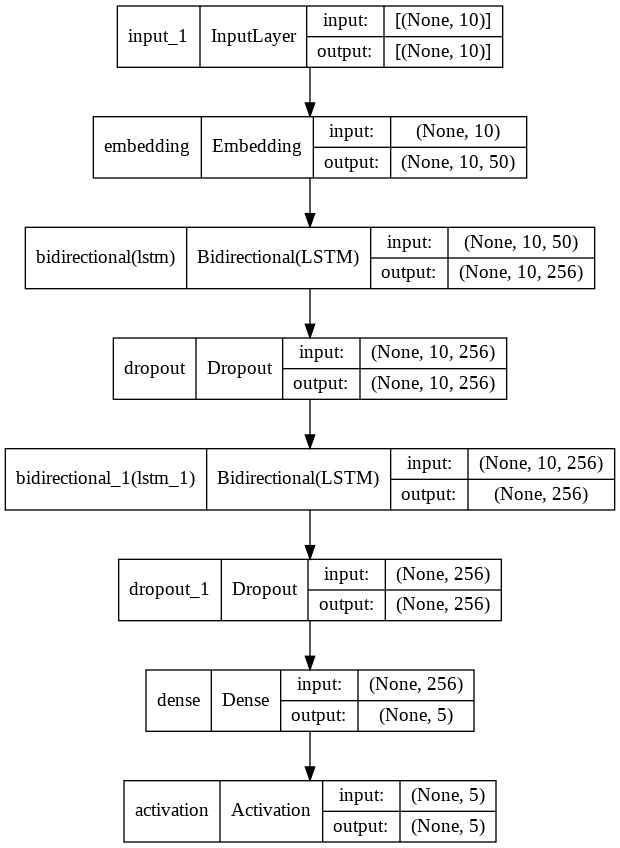

In [13]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
early = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=15)  
checkpoint = ModelCheckpoint('best_model.h5',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)  

In [15]:
X_train_indices = sentences_to_indices(X_train,word_to_index,MAX_SENTENCE_LEN)
Y_train_oh = convert_to_one_hot(Y_train,N_CLASSES)
X_test_indices = sentences_to_indices(X_test,word_to_index,MAX_SENTENCE_LEN)
Y_test_oh = convert_to_one_hot(Y_test,N_CLASSES)

In [16]:
history = model.fit(X_train_indices,
                    Y_train_oh,
                    validation_data=(X_test_indices,Y_test_oh),
                    epochs=50,
                    batch_size=16,
                    shuffle=True,
                    callbacks=[early,checkpoint])

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.5310 - accuracy: 0.3267
Epoch 00001: val_accuracy improved from -inf to 0.34211, saving model to best_model.h5
10/10 [==============================] - 18s 503ms/step - loss: 1.5310 - accuracy: 0.3267 - val_loss: 1.5034 - val_accuracy: 0.3421
Epoch 2/50
 9/10 [==========================>...] - ETA: 0s - loss: 1.3209 - accuracy: 0.5694
Epoch 00002: val_accuracy improved from 0.34211 to 0.42105, saving model to best_model.h5
10/10 [==============================] - 1s 91ms/step - loss: 1.3164 - accuracy: 0.5733 - val_loss: 1.2425 - val_accuracy: 0.4211
Epoch 3/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.9785 - accuracy: 0.6875
Epoch 00003: val_accuracy improved from 0.42105 to 0.63158, saving model to best_model.h5
10/10 [==============================] - 1s 88ms/step - loss: 0.9704 - accuracy: 0.7000 - val_loss: 0.9781 - val_accuracy: 0.6316
Epoch 4/50
 9/10 [==========================>...] - ETA: 0s

# 5. Plot loss and accuracy

In [17]:
sn.set(font_scale=1.5) # for label size

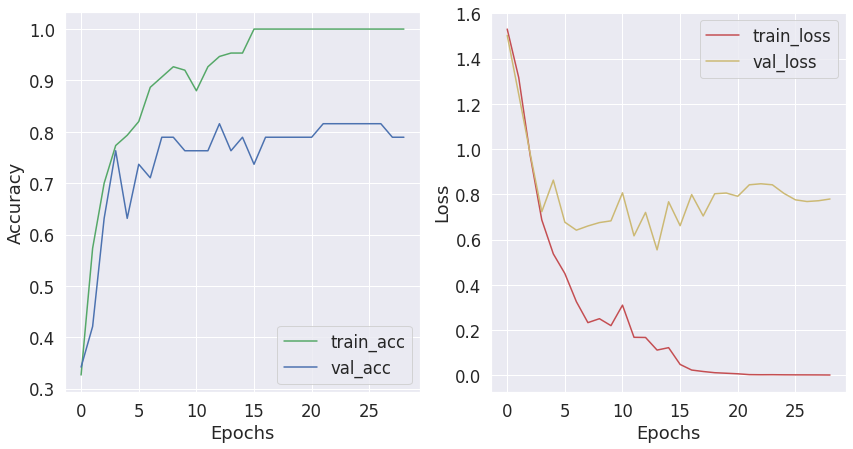

In [18]:
def plot_history(history):
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    fig, ax = plt.subplots(1,2,figsize=(14,7))
    
    ax[0].plot(train_acc,label='train_acc',c='g')
    ax[0].plot(val_acc,label='val_acc',c='b')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(train_loss,label='train_loss',c='r')
    ax[1].plot(val_loss,label='val_loss',c='y')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

plot_history(history)

In [19]:
loss, acc = model.evaluate(X_test_indices,Y_test_oh,batch_size=16)
print(f'Test accuracy = {acc}')

3/3 [==============================] - 0s 14ms/step - loss: 0.7795 - accuracy: 0.7895
Test accuracy = 0.7894737124443054


In [20]:
Y_pred = model.predict(X_test_indices)
counter = 1
for i in range(len(X_test)):
    x = X_test_indices
    predicted_label = np.argmax(Y_pred[i])
    if predicted_label != Y_test[i]:
        print(f'Phrase #{counter}: {X_test[i]}')
        print(f'Expected: {label_to_emoji(Y_test[i])}, predicted: {label_to_emoji(predicted_label).strip()}')
        counter += 1

Phrase #1: family is all i have
Expected: ❤️, predicted: 😞
Phrase #2: stop shouting at me
Expected: 😞, predicted: 😄
Phrase #3: stop shouting at me
Expected: 😞, predicted: 😄
Phrase #4: she is a bully
Expected: 😞, predicted: ❤️
Phrase #5: i think i will end up alone
Expected: 😞, predicted: 😄
Phrase #6: candy is life
Expected: 😄, predicted: ❤️
Phrase #7: do you want to give me a hug
Expected: ❤️, predicted: 😄
Phrase #8: will you be my valentine
Expected: 😄, predicted: 😞


In [21]:
matrix = confusion_matrix(Y_test_oh.argmax(axis=1),Y_pred.argmax(axis=1))

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9918 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127860 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9918 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127860 missing from current font.
  font.set_text(s, 0, flags=flags)


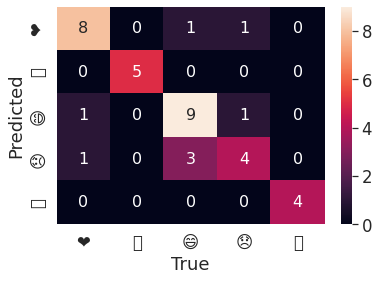

In [22]:
df_cm = pd.DataFrame(matrix,[label_to_emoji(i) for i in range(5)],[label_to_emoji(i) for i in range(5)])
sn.heatmap(df_cm,annot=True,annot_kws={'size':16}) # font size
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()